Triplet loss is a technique belonging to constrastive learning, which, in its turn, is a subfield of unsupervised learning. It is used to learn embeddings from prior knowledge of items (anchors), items similar to the anchor (positives) and items opposite to the achor (negatives). 

#### How is it applicable in the real world?
This technique is used to learn meaningful embeddings of any type of data. For **example**, when we're recommending the next best basket after a user has already moved to checkout. We can then use KNN after training our network on learning embeddings through anchors being user carts, positives being next items to be added to the cart and negatives - all other items that the user has looked over, but never decided to put into the cart with the rest. As another example, a FaceNet model (https://arxiv.org/pdf/1503.03832) used to find similar faces based on the same triplet loss.

#### What is the logic behind the triplet loss
* An explanation is taken from this amazing video-course: https://www.youtube.com/watch?v=d2XB5-tuCWU&t=146s . Suppose we're trying to teach our network create embeddings for images in a way that we can decipher from old people and young people, i.e.:
    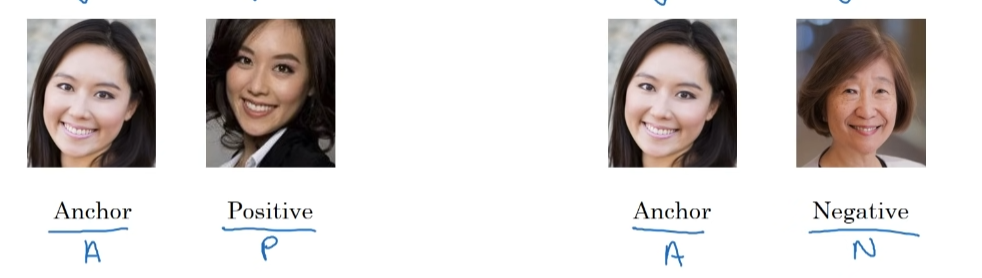

* We'll build some arbitrary network $NN$ that returns an embedding for the image. Considering the problem, we'll need to be able to learn parameters of the network under the following condition: $||NN(A)-NN(P)||_2-||NN(A)-NN(N)||_2\geq 0$ (difference between distance of "anchor" and "positive" must be as small as possible compared to distance between "anchor" and "negative"). This would lead us, however, to $NN(anything)=0$, because this would yeild ideal result of difference being equal to 0. 
* To tackle this problem we introduce a hyperparameter $\alpha$, that would be a margin between the furthest positive example and the closest negative. Hence, our inequality is transformed to: $||NN(A)-NN(P)||_2-||NN(A)-NN(N)||_2\geq 0 - \alpha \implies ||NN(A)-NN(P)||_2-||NN(A)-NN(N)||_2 +\alpha\geq 0$. Hence the loss function will look like $L(A,P,N)=max(||NN(A)-NN(P)||_2-||NN(A)-NN(N)||_2 +\alpha, 0)$. We'll then do a classic gradient descend in the direction of minimizing this function.
    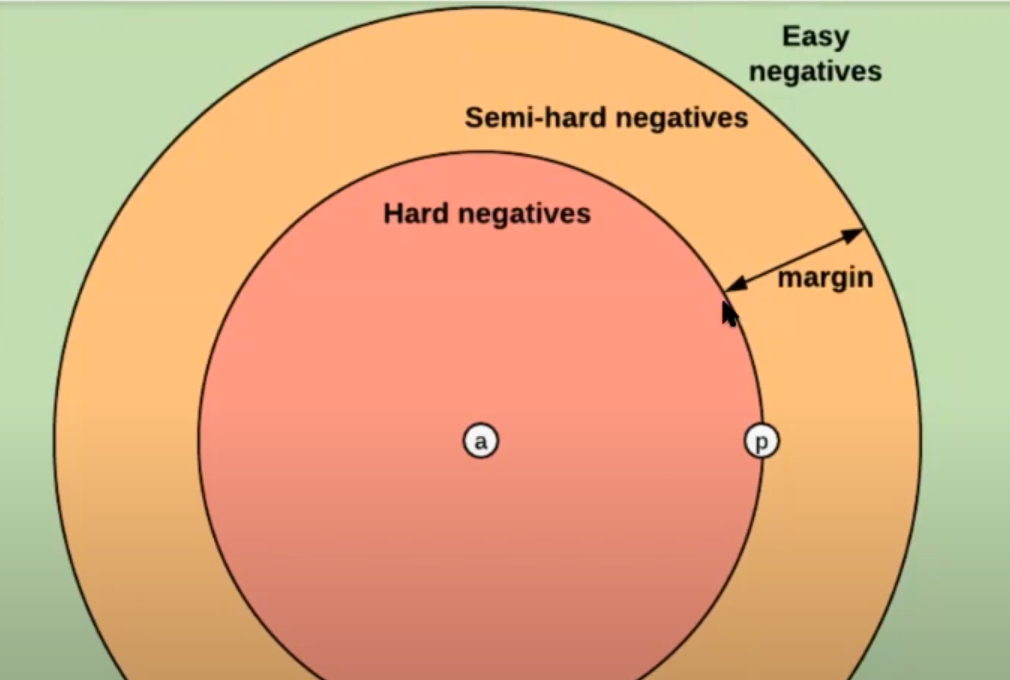

* This type of loss is called semi-hard triplet loss, because we introduce margin parameter, that, just like in SVM, introduces biases into our model. A strictier approach, can be applied by removing $\alpha$, applying softmax to them, mapping differences against their true labels (0/1 for smallest and largest) and calcualting a trivial BCE (just like demonstrated here: https://youtu.be/dG8le1YWUI8?t=1187).

In fact we'll use the same AE network developed in `auto_encoder.ipynb` and compare its performance against MSE loss. We'll use the same MNIST dataset to be percise. However instead of simple dataloaders, we're going to create a separate dataset on top of MNIST that randomly samples data from train/test set of the MNIST dataset and finds random positives and negatives for it.

In [63]:
from typing import Any, Tuple
import torchvision
import torch
from torchvision import transforms
from torch.utils import data

class transformedDS(data.Dataset):

    def __init__(self, transformations, train: bool = True) -> None:
        self.ds = torchvision.datasets.MNIST(
            root='./data/vision',
            train=train,
            transform=transformations,
            download=True)
        self.all_labels =  torch.Tensor(
            [self.ds[i][1] for i in range(len(self.ds))]
        )
        self.all_indices = torch.arange(0,len(self.ds))
        
    def __len__(self):
        return len(self.ds)

    def __getitem__(self, index) -> Tuple[Any, Any]:
        """ 
        :returns: a single tuple of anchor, positive and negative 
        """

        rand_sample = torch.randint(low=0,high=len(self.ds),size=(1,)).item()
        label = self.ds[rand_sample][1]

        # getting random positives for an anchor
        rand_shuffle = torch.randperm(len(self.ds))
        positive = self.all_indices[self.all_labels == label]
        positive = rand_shuffle[torch.isin(rand_shuffle,positive)][0].item()

        # getting random negatives for an anchor
        rand_shuffle = torch.randperm(len(self.ds))
        negative = self.all_indices[self.all_labels != label]
        negative = rand_shuffle[torch.isin(rand_shuffle,negative)][0].item()

        return (self.ds[rand_sample], self.ds[positive], self.ds[negative])


transformations = torchvision.transforms.Compose([
    transforms.ToTensor(), transforms.Normalize(0, 1)
])

train_ds, test_ds = transformedDS(transformations, train=True), \
    transformedDS(transformations, train=False)

# pin_memory allows dedicated faster paging of the data
# between CPU and GPU: https://developer.nvidia.com/blog/how-optimize-data-transfers-cuda-cc/#pinned_host_memory
# we're also choosing 8x8 workers, because of 16 total cores on CPU
train_dl, test_dl = data.DataLoader(train_ds, 64, shuffle=True, num_workers=0), \
    data.DataLoader(test_ds, 64, shuffle=False, num_workers=0)

len(train_dl), len(test_dl)

(938, 157)

This solutions is a pretty good workaround, because even torch DataLoader will be able to create batches on such data:

In [64]:
# print out information on the first batch of the train
# dataloader

for batch in train_dl:
    anchor, positive, negative = 0, 1, 2
    print(f'Number of triplet batches inside the general batch: {len(batch)}')
    print(f'Anchor shape size: {batch[anchor][0].shape}')
    print(f'Positives shape size: {batch[positive][0].shape}')
    print(f'Negatives shape size: {batch[negative][0].shape}')
    break

Number of triplet batches inside the general batch: 3
Anchor shape size: torch.Size([64, 1, 28, 28])
Positives shape size: torch.Size([64, 1, 28, 28])
Negatives shape size: torch.Size([64, 1, 28, 28])


And more importantly we can verify that our dataset has recieved a good generation by taking a look at first six anchors:

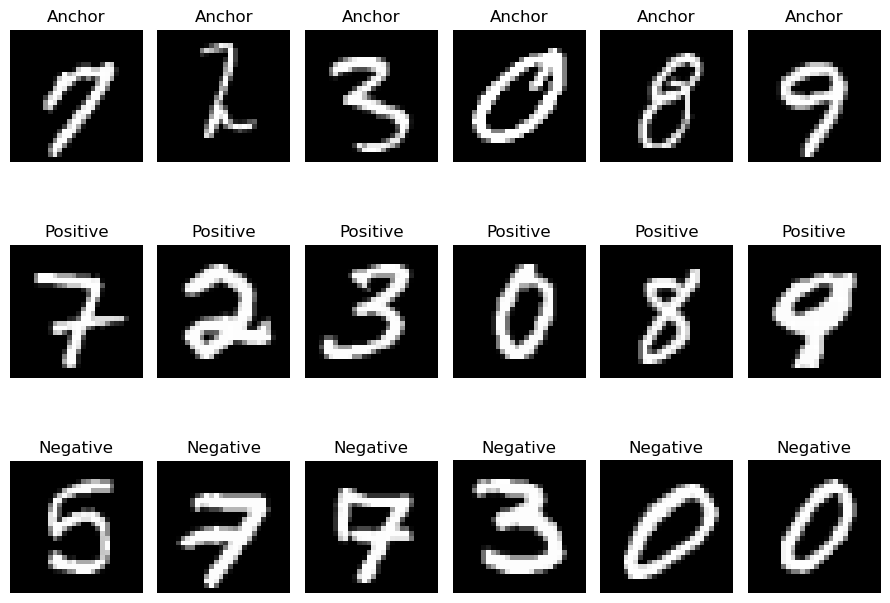

In [3]:
import matplotlib.pyplot as plt

cols = 6
fig, axs = plt.subplots(3,cols,figsize=(9,7))
for i, triplet in enumerate(train_ds):
    if i == cols:
        break
    
    anchor, pos, neg = triplet[0][0], triplet[1][0], triplet[2][0]
    x = i % cols

    axs[0, x].imshow(anchor[0], cmap="gray")
    axs[0, x].set(title='Anchor')
    axs[0, x].axis('off')

    axs[1, x].imshow(pos[0], cmap="gray")
    axs[1, x].set(title='Positive')
    axs[1, x].axis('off')

    axs[2, x].imshow(neg[0], cmap="gray")
    axs[2, x].set(title='Negative')
    axs[2, x].axis('off')
    

fig.tight_layout()

Now we define the same AE network with only one hidden layer and $k=32$ latent factors:

In [90]:
import torch
from torch import nn

class AE(nn.Module):

    def __init__(self, k, dropout=.01, input_shape=64, *args, **kwargs) -> None:
        """ 
        - k: int
            - Number of latent factors
        - dropout: float
            - Dropout rate
        """

        super().__init__(*args, **kwargs)
        self.k = k
        self.dropout = dropout
        self.input_shape = input_shape

        self.e_proj = nn.Linear(
            input_shape, k)
        self.encfc = nn.Linear(k, k)
        self.enc_dec_proj = nn.Linear(k, k)
        self.d_out = nn.Linear(
            k, input_shape)
        self.gelu = nn.GELU()
        self.relu = nn.ReLU()
        self.drop = nn.Dropout(dropout)
        
    def forward(self, x):
        x = self.e_proj(x)
        x = self.gelu(x)
        x = self.encfc(x)
        x = self.relu(x)
        x = self.enc_dec_proj(x)
        x = self.gelu(x)
        return self.gelu(self.d_out(x))

In [91]:
imgDims = torch.prod(torch.tensor(train_ds[0][0][0].shape), 0).item()
device = 'cuda' if torch.cuda.is_available() else 'cpu'
aeModel = AE(k=32,input_shape=imgDims).to(device)
print(f'latent_factors=32 :: input={imgDims}')
aeModel

latent_factors=32 :: input=784


AE(
  (e_proj): Linear(in_features=784, out_features=32, bias=True)
  (encfc): Linear(in_features=32, out_features=32, bias=True)
  (enc_dec_proj): Linear(in_features=32, out_features=32, bias=True)
  (d_out): Linear(in_features=32, out_features=784, bias=True)
  (gelu): GELU(approximate='none')
  (relu): ReLU()
  (drop): Dropout(p=0.01, inplace=False)
)

Now let's build a simple semi-hard triplet loss as well as the hard triplet loss (that in practice did not work out that great):

In [92]:
hard_criterion = nn.BCELoss().to(device)

class EuclideanDist(nn.Module):

    def __init__(self, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)

    def forward(self, anchor, posneg):
        return torch.norm(anchor - posneg)

class SoftMarginTripletLoss(nn.Module):
    
    def __init__(self, alpha: float = .2, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.alpha = alpha
        self.euclid = EuclideanDist().to(device)

    def forward(self, positive, negative, anchor):
        lossfn = self.euclid(anchor, positive) - \
                         self.euclid(anchor, negative) + self.alpha
        return lossfn - lossfn*(lossfn < 0)
    
class HardTripletLoss(nn.Module):
    
    def __init__(self, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.softmax = nn.Softmax(dim=0)

    def forward(self, positive, negative, anchor):
        l1Pos, l1Neg = torch.subtract(anchor,positive).abs().sum(dim=1), \
            torch.subtract(anchor,negative).abs().sum(dim=1)
        posneg = self.softmax(torch.hstack([l1Pos,l1Neg]))
        dist = torch.hstack([torch.ones(l1Pos.shape),
                             torch.zeros(l1Neg.shape)]).to(device)
        return hard_criterion(posneg,dist)

And then we define the Triplet loss as well as the same SGD optimizer

In [93]:
trainParams = {
    'lr': .001,
    'max_epochs': 200,
    'momentum': .08,
    'w_decay': .05,
    'verbose': 20
}

torch.cuda.empty_cache()

optimizer_SGD = torch.optim.SGD(aeModel.parameters(), 
                             lr=trainParams['lr'],
                             momentum=trainParams['momentum'],
                             weight_decay=trainParams['w_decay'])
optimizer = torch.optim.Adam(aeModel.parameters(),lr=trainParams['lr'])
criterion = SoftMarginTripletLoss().to(device)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, patience=10)
# criterion = HardTripletLoss().to(device)

And finally run the training. Although, since we're doing a lot of `.item()` (that transfters everything from CUDA to CPU) inside the dataset for generations, we'll be required to collect all the training data first if we want to speed up operations. Otherwise the `it/s` speed is going to be below the $10$ mark. For the sake of simplicity, we're also going to decrease the number of collected batches to 150 instead of original 900+, since the generative component of the dataset ensures randomnicity of anchors and their corresponding positives and negatives.

In [72]:
from tqdm import tqdm

data = []

for i, batch in tqdm(enumerate(train_dl)):
    data.append(batch)
    if i == 149:
        print(f'[v] iteration over {i+1} batch')
        break

149it [02:15,  1.10it/s]

[v] iteration over 150 batch


In [95]:
from sklearn.metrics import r2_score

avTripletLosses = []
R2Scores = []
for epoch in tqdm(range(trainParams['max_epochs'])):
    tripletLosses = []
    x, xHat = [], []
    for (anchor, positive, negative) in data:
        img_anchor = anchor[0].view(-1,imgDims).to(device)
        img_pos = positive[0].view(-1,imgDims).to(device)
        img_neg = negative[0].view(-1,imgDims).to(device)

        # we're zeroing gradients, because by 
        # default they're being accumulated,
        # which is not needed for AE, unlike
        # RNNs or other sequential models
        optimizer_SGD.zero_grad()

        out = aeModel(img_anchor)
        loss = criterion(img_pos, img_neg, out)
        tripletLosses.append(loss.cpu().detach())
        scheduler.step(loss)

        loss.backward()
        optimizer_SGD.step()

        # collecting samples for R^2
        x.append(img_anchor.cpu().detach())
        xHat.append(out.cpu().detach())

    avTripletLosses.append(torch.hstack(tripletLosses).mean().item())
    R2Scores.append(r2_score(torch.vstack(x).numpy(),torch.vstack(xHat).numpy()))

    if epoch % trainParams['verbose'] == 0:
        print(f'epoch: {epoch+1} ::', 
              f'av. MSE: {avTripletLosses[-1]} ::',
              f':: R^2: {R2Scores[-1]}')

  0%|          | 1/200 [00:00<01:33,  2.14it/s]

epoch: 1 :: av. MSE: 1.0961216688156128 :: :: R^2: -70.99010727459122


 10%|█         | 21/200 [00:08<01:13,  2.43it/s]

epoch: 21 :: av. MSE: 1.088627576828003 :: :: R^2: -55.21732149332755


 20%|██        | 41/200 [00:16<01:02,  2.54it/s]

epoch: 41 :: av. MSE: 1.083269476890564 :: :: R^2: -41.564029576356056


 30%|███       | 61/200 [00:24<00:57,  2.40it/s]

epoch: 61 :: av. MSE: 1.0786274671554565 :: :: R^2: -31.144728447459833


 40%|████      | 81/200 [00:32<00:46,  2.58it/s]

epoch: 81 :: av. MSE: 1.0744168758392334 :: :: R^2: -23.26158884019481


 50%|█████     | 101/200 [00:40<00:41,  2.36it/s]

epoch: 101 :: av. MSE: 1.0704894065856934 :: :: R^2: -17.337461485712588


 60%|██████    | 121/200 [00:48<00:30,  2.55it/s]

epoch: 121 :: av. MSE: 1.0668736696243286 :: :: R^2: -12.921362484172072


 70%|███████   | 141/200 [00:57<00:23,  2.51it/s]

epoch: 141 :: av. MSE: 1.063438057899475 :: :: R^2: -9.648031022320874


 80%|████████  | 161/200 [01:05<00:16,  2.36it/s]

epoch: 161 :: av. MSE: 1.0601019859313965 :: :: R^2: -7.232455636860987


 90%|█████████ | 181/200 [01:13<00:07,  2.54it/s]

epoch: 181 :: av. MSE: 1.0567865371704102 :: :: R^2: -5.458621151539807


100%|██████████| 200/200 [01:21<00:00,  2.47it/s]


Compared to a simple MSE loss we're getting much smoother graph:

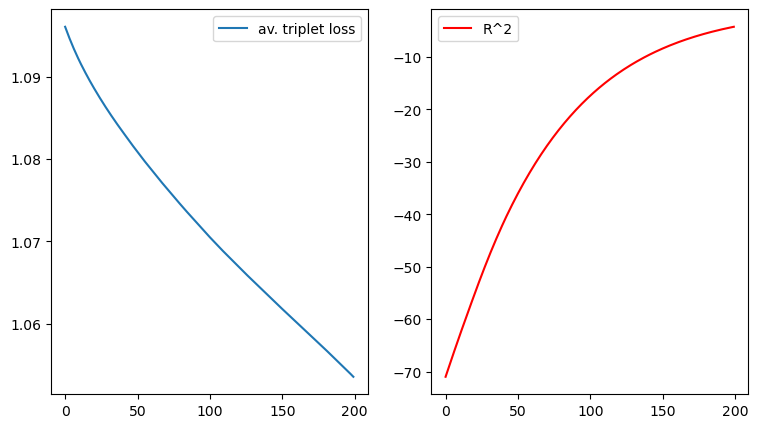

In [97]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1,2,figsize=(9,5))
axs[0].plot(avTripletLosses, label='av. triplet loss')
axs[0].legend(loc='best')
axs[1].plot(R2Scores, label='R^2', c='red')
axs[1].legend(loc='best')

Of course the point of the triplet loss is finding embeddings that represent similarities in data the best, therefore it's more interesting to explore how good is the model at finding the closest item. For that matter we'll build an inference function that will yield us an AE embedding of lower dimensions and we'll then calculate distances across all samples in some set of data

In [138]:
from torch.nn.functional import cosine_similarity as cossim

def gen_embedding(anchor):
    """ 
    Compress and generate a meaningful_embedding
    """

    aeModel.eval()

    with torch.no_grad():
        imgAsVec = anchor.view(-1, imgDims).to(device)
        out = aeModel(imgAsVec)

    aeModel.train()
    return out.cpu().detach()

def find_top_k(img_idx, k: int, d):
    """ 
    - img_idx: int
        - against which image we're calculating similarities
    - k: int
        - number of k nearest
    - d: torch.Tensor
        - array of data
    """
    embeddings = torch.vstack(
        [gen_embedding(img) for img in d]
    )
    img_embedding = gen_embedding(d[img_idx])
    topKIndices = cossim(img_embedding, 
                             embeddings)\
                                .argsort(descending=True)[:k]
    return topKIndices

Next step is getting rid of negatives and positives that are still present in the batched data. We don't want to generate anything new for now, so we'll iterate over previously generated `data` once again

In [133]:
# tansform batches into a tensor of anchors

anchors = [batch[0][0] for batch in data]
anchors = torch.vstack(anchors)
anchors.shape

torch.Size([9600, 1, 28, 28])

If we try getting closest images to the first "anchor" image, we'll be getting fairly descent results. Most of images indeed show similar traits to the number $1$ that is the "anchor image":

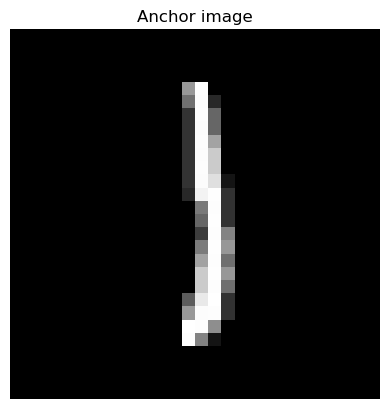

In [142]:
first_img = anchors[0]
plt.imshow(first_img[0], cmap='gray')
plt.title('Anchor image')
plt.axis('off')
None

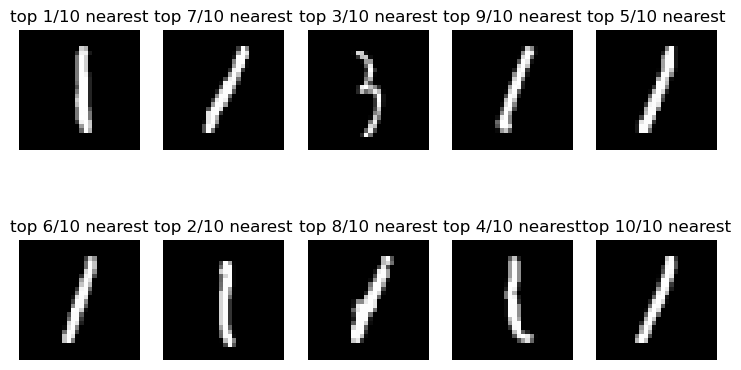

In [143]:
rows, cols = 2, 5
topKEmbeds = find_top_k(0,10,anchors).tolist()
fig, axs = plt.subplots(rows, cols, figsize=(9,5))

for i in range(len(topKEmbeds)):
    x, y = i % cols, i % rows
    axs[y, x].imshow(anchors[topKEmbeds[i]][0], cmap="gray")
    axs[y, x].set(title=f'top {i+1}/10 nearest')
    axs[y, x].axis('off')